# Exploration 6: Sentiment Analysis on Movie Reviews

---

#### Model
* GlobalMaxPooling1D
* 1-D CNN
* LSTM

#### Datasets
* Naver Sentiment Movie Corpus

#### Goals

1. To use multiple models
2. To use gensim and Word2Vec
3. Accuracy higher than 85%

---

## Importing Dependencies

laying the foundation to build my model on

In [1]:
import os, re, gensim, urllib.request
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

print("All imported!")

All imported!


---

## Data Pre-processing


### Importing data

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


looks like label 0 is the negatives and 1 is the positives

### Data loader

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# Data loader function
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # Dictionary
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("number of train data: {}, number of test data: {}".format(len(X_train), len(X_test)))

index_to_word = {index:word for word, index in word_to_index.items()}

number of train data: 146182, number of test data: 49157


In [4]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

for i in range(5):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('Label: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
Label:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
Label:  1
[24, 205, 2]
재 <UNK>
Label:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
Label:  0
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
Label:  1


### Data analysis

In [5]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('average sentence length: ', np.mean(num_tokens))
print('max sentence length: ', np.max(num_tokens))
print('sentence length standard deviation: ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('{}% of all sentences lies within the range of set maxlen value'.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

average sentence length:  15.96940191154864
max sentence length:  116
sentence length standard deviation:  12.843571191092
pad_sequences maxlen:  41
93.42988343341575% of all sentences lies within the range of set maxlen value


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


* padding is added in front of the sentences

In [7]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1028,    4,   11,  519,  549,  687,    5,  120,    4,
         70, 1639,   52,  925, 1006,   15,   44,  391], dtype=int32)

---
## Model Construction, Compile and Fit

In [8]:
vocab_size = 10000
word_vector_dim = 32

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=7)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

### 1. GlobalMaxPooling1D

In [11]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [58]:
model1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=30

history1 = model1.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping],
                      verbose=1)

Epoch 1/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.1573 - accuracy: 0.9407 - val_loss: 0.5074 - val_accuracy: 0.8306
Epoch 2/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.1417 - accuracy: 0.9476 - val_loss: 0.5472 - val_accuracy: 0.8255
Epoch 3/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.1231 - accuracy: 0.9557 - val_loss: 0.5835 - val_accuracy: 0.8257
Epoch 4/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.1097 - accuracy: 0.9614 - val_loss: 0.6329 - val_accuracy: 0.8228
Epoch 5/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.0989 - accuracy: 0.9656 - val_loss: 0.6703 - val_accuracy: 0.8198
Epoch 6/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.0886 - accuracy: 0.9690 - val_loss: 0.7009 - val_accuracy: 0.8182
Epoch 7/30
1828/1828 [==============================] - 6s 3ms/step - loss: 0.0789 - accuracy: 0.9732 - val_loss: 0.7648 - val_accuracy:

In [96]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
print(results1)

1537/1537 - 2s - loss: 0.8959 - accuracy: 0.8099
[0.8959338665008545, 0.8099151849746704]


### 2. 1-D CNN

In [14]:
model2 = keras.Sequential(name='CNN')
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.5036 - accuracy: 0.7341 - val_loss: 0.3686 - val_accuracy: 0.8395
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3227 - accuracy: 0.8628 - val_loss: 0.3498 - val_accuracy: 0.8497
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2833 - accuracy: 0.8826 - val_loss: 0.3497 - val_accuracy: 0.8502
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2458 - accuracy: 0.9009 - val_loss: 0.3634 - val_accuracy: 0.8485
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2021 - accuracy: 0.9232 - val_loss: 0.3852 - val_accuracy: 0.8449
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1572 - accuracy: 0.9439 - val_loss: 0.4274 - val_accuracy: 0.8420
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1188 - accuracy: 0.9604 - val_loss: 0.4821 - val_accuracy: 0.8393
Epoch 

In [97]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)

1537/1537 - 2s - loss: 0.8208 - accuracy: 0.8252
[0.8208118677139282, 0.8251927495002747]


### 3. LSTM

In [17]:
model3 = keras.Sequential(name='LSTM')
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [18]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.4810 - accuracy: 0.7870 - val_loss: 0.3712 - val_accuracy: 0.8404
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3364 - accuracy: 0.8588 - val_loss: 0.3619 - val_accuracy: 0.8440
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3153 - accuracy: 0.8694 - val_loss: 0.3616 - val_accuracy: 0.8447
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3028 - accuracy: 0.8745 - val_loss: 0.3639 - val_accuracy: 0.8443
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2930 - accuracy: 0.8790 - val_loss: 0.3643 - val_accuracy: 0.8447
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2849 - accuracy: 0.8832 - val_loss: 0.3672 - val_accuracy: 0.8451
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2758 - accuracy: 0.8875 - val_loss: 0.3687 - val_accuracy: 0.8445
Epoch 

In [98]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)
print(results3)

1537/1537 - 3s - loss: 0.3979 - accuracy: 0.8449
[0.3979060649871826, 0.8449050784111023]


### accuracy and loss graphs

In [60]:
history1_dict = history1.history
history2_dict = history2.history
history3_dict = history3.history

print(history1_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

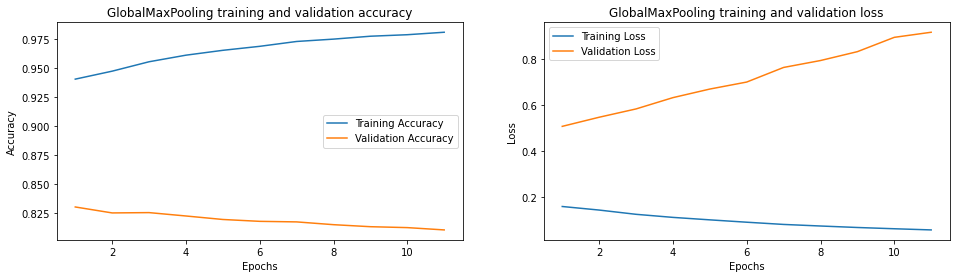

In [61]:
#GlobalMaxPooling1D
acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('GlobalMaxPooling training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('GlobalMaxPooling training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

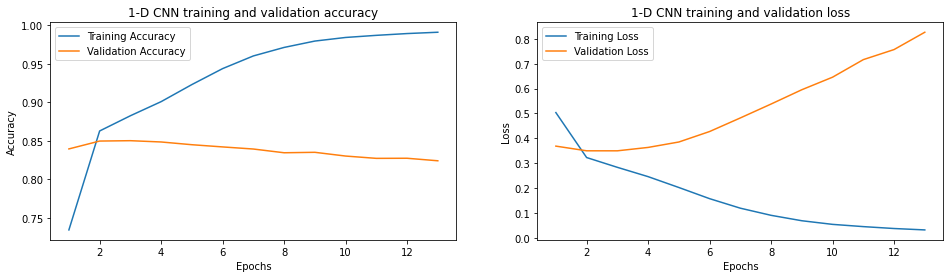

In [22]:
#1-D CNN
acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('1-D CNN training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('1-D CNN training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

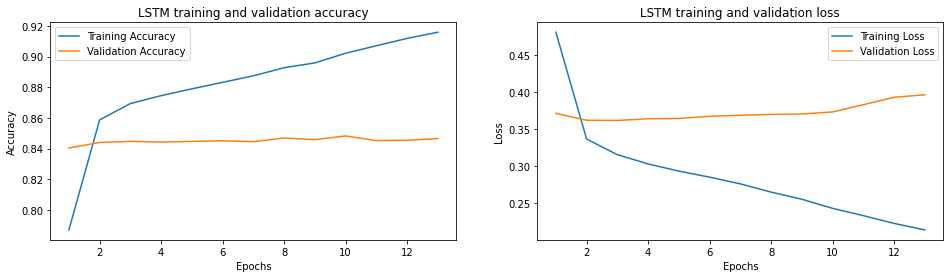

In [23]:
#LSTM
acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('LSTM training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('LSTM training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Embedding layer analysis

In [24]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [25]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [27]:
vector = word_vectors['감동']
vector

array([ 0.17380646,  0.28894696, -0.10418054,  0.03672168,  0.13409118,
        0.06237672,  0.07462927, -0.00829997,  0.17591566, -0.11348925,
       -0.03901356, -0.21748222, -0.05198418,  0.1294495 , -0.23913479,
        0.1208543 , -0.07131209, -0.21806547,  0.13024566,  0.13290158,
       -0.20268025, -0.08058907,  0.05973604,  0.09884182,  0.11379284,
        0.05255895,  0.0931486 ,  0.14042406, -0.11010145, -0.04521723,
        0.10535672, -0.05575649], dtype=float32)

In [28]:
word_vectors.similar_by_word("황홀")

[('주옥같', 0.9799162745475769),
 ('am', 0.978428840637207),
 ('love', 0.9760814905166626),
 ('덴젤워싱턴', 0.9754340052604675),
 ('Best', 0.9750730991363525),
 ('best', 0.9731928110122681),
 ('예뻐요', 0.9729690551757812),
 ('Good', 0.9726728200912476),
 ('♥', 0.9720125198364258),
 ('♥♥', 0.9719205498695374)]

## Korean Word2Vec embedding

In [29]:
import gensim
gensim.__version__

'3.8.3'

the version needs to be downgraded to 3.8.3<br/>
before downgrading: v 4.1.2

In [31]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape

/tmp/ipykernel_1811/239434341.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [34]:
word2vec.similar_by_word("감동")

/tmp/ipykernel_1811/219167998.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("감동")


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [35]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_1811/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [36]:
vocab_size = 10000    # size of the dictionary (10,000 vocabularies)
word_vector_dim = 200  # adjustable hyperparameter

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1811/704438165.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1811/704438165.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [48]:
#new model with GlobalMaxPooling1D
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
model4.add(keras.layers.GlobalMaxPooling1D())
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [71]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history4 = model4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
457/457 [==============================] - 2s 5ms/step - loss: 0.0050 - accuracy: 0.9972 - val_loss: 2.2916 - val_accuracy: 0.8078
Epoch 2/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0049 - accuracy: 0.9972 - val_loss: 2.4132 - val_accuracy: 0.8011
Epoch 3/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0061 - accuracy: 0.9966 - val_loss: 2.2765 - val_accuracy: 0.8088
Epoch 4/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0046 - accuracy: 0.9972 - val_loss: 2.2728 - val_accuracy: 0.8090
Epoch 5/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0046 - accuracy: 0.9973 - val_loss: 2.2117 - val_accuracy: 0.8077
Epoch 6/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0047 - accuracy: 0.9972 - val_loss: 2.3162 - val_accuracy: 0.8095
Epoch 7/15
457/457 [==============================] - 2s 4ms/step - loss: 0.0046 - accuracy: 0.9972 - val_loss: 2.2996 - val_accuracy: 0.8093
Epoch 

In [72]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 2.3512 - accuracy: 0.8087


<Figure size 432x288 with 0 Axes>

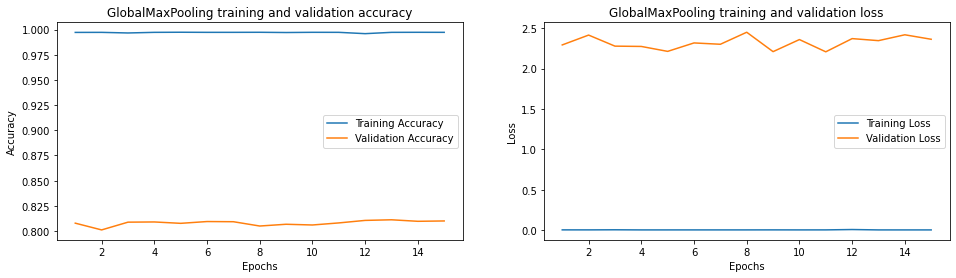

In [75]:
history4_dict = history4.history

acc = history4_dict['accuracy']
val_acc = history4_dict['val_accuracy']
loss = history4_dict['loss']
val_loss = history4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('GlobalMaxPooling training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('GlobalMaxPooling training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [86]:
#new model with 1-D CNN
model5 = keras.Sequential(name='newCNN')
model5.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
model5.add(keras.layers.Conv1D(16, 7, activation='relu'))
model5.add(keras.layers.MaxPooling1D(5))
model5.add(keras.layers.Conv1D(16, 7, activation='relu'))
model5.add(keras.layers.GlobalMaxPooling1D())
model5.add(keras.layers.Dense(8, activation='relu'))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "newCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9    

In [91]:
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history5 = model5.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
914/914 [==============================] - 5s 5ms/step - loss: 0.0956 - accuracy: 0.9663 - val_loss: 0.6171 - val_accuracy: 0.8357
Epoch 2/5
914/914 [==============================] - 5s 5ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 0.6727 - val_accuracy: 0.8342
Epoch 3/5
914/914 [==============================] - 5s 5ms/step - loss: 0.0717 - accuracy: 0.9757 - val_loss: 0.7137 - val_accuracy: 0.8363
Epoch 4/5
914/914 [==============================] - 5s 5ms/step - loss: 0.0636 - accuracy: 0.9785 - val_loss: 0.7704 - val_accuracy: 0.8347
Epoch 5/5
914/914 [==============================] - 5s 5ms/step - loss: 0.0596 - accuracy: 0.9800 - val_loss: 0.8265 - val_accuracy: 0.8341


In [92]:
results5 = model5.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.8196 - accuracy: 0.8351


<Figure size 432x288 with 0 Axes>

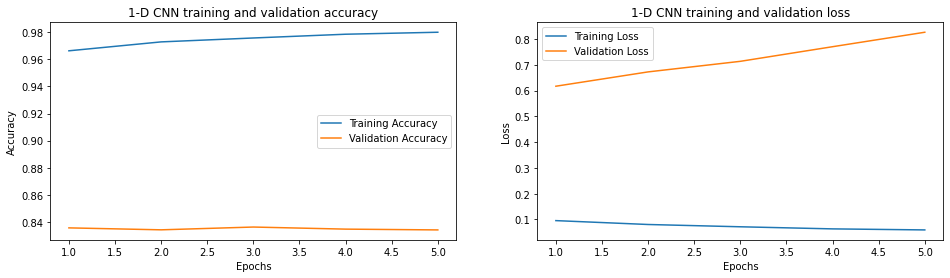

In [93]:
history5_dict = history5.history

acc = history5_dict['accuracy']
val_acc = history5_dict['val_accuracy']
loss = history5_dict['loss']
val_loss = history5_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('1-D CNN training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('1-D CNN training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [44]:
# new model with LSTM
model6 = keras.Sequential(name='newLSTM')
model6.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
model6.add(keras.layers.LSTM(512))
model6.add(keras.layers.Dense(8, activation='relu'))
model6.add(keras.layers.Dense(1, activation='sigmoid'))

model6.summary()

Model: "newLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 4104      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [45]:
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history6 = model6.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 18s 73ms/step - loss: 0.4509 - accuracy: 0.7824 - val_loss: 0.3675 - val_accuracy: 0.8408
Epoch 2/20
229/229 [==============================] - 16s 70ms/step - loss: 0.3152 - accuracy: 0.8639 - val_loss: 0.3336 - val_accuracy: 0.8579
Epoch 3/20
229/229 [==============================] - 16s 68ms/step - loss: 0.2666 - accuracy: 0.8886 - val_loss: 0.3258 - val_accuracy: 0.8621
Epoch 4/20
229/229 [==============================] - 15s 68ms/step - loss: 0.2302 - accuracy: 0.9048 - val_loss: 0.3286 - val_accuracy: 0.8653
Epoch 5/20
229/229 [==============================] - 16s 68ms/step - loss: 0.1909 - accuracy: 0.9239 - val_loss: 0.3531 - val_accuracy: 0.8600
Epoch 6/20
229/229 [==============================] - 16s 69ms/step - loss: 0.1492 - accuracy: 0.9415 - val_loss: 0.3901 - val_accuracy: 0.8630
Epoch 7/20
229/229 [==============================] - 16s 69ms/step - loss: 0.1103 - accuracy: 0.9579 - val_loss: 0.4477 - val_accuracy:

In [46]:
results6 = model6.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.7958 - accuracy: 0.8561


<Figure size 432x288 with 0 Axes>

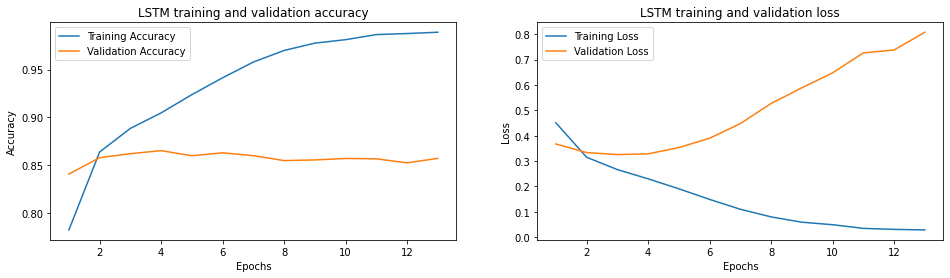

In [47]:
history6_dict = history6.history

acc = history6_dict['accuracy']
val_acc = history6_dict['val_accuracy']
loss = history6_dict['loss']
val_loss = history6_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('LSTM training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('LSTM training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [104]:
print('Comparing GlobalMaxPooling1D')
print('loss and accuracy:' , (results1))
print('loss and accuracy:' ,results4)
print('Comparing 1-D CNN')
print('loss and accuracy:' ,results2)
print('loss and accuracy:' ,results5)
print('Comparing LSTM')
print('loss and accuracy:' ,results3)
print('loss and accuracy:' ,results6)

Comparing GlobalMaxPooling1D
loss and accuracy: [0.8959338665008545, 0.8099151849746704]
loss and accuracy: [2.3512260913848877, 0.8087352514266968]
Comparing 1-D CNN
loss and accuracy: [0.8208118677139282, 0.8251927495002747]
loss and accuracy: [0.8195919990539551, 0.8350591063499451]
Comparing LSTM
loss and accuracy: [0.3979060649871826, 0.8449050784111023]
loss and accuracy: [0.7957519888877869, 0.8560733795166016]


---

## Conclusion

#### Final model accuracy: 86%

* 1-D CNN and LSTM were able to improve by using Word2Vec but didn't work for GlobalMaxPooling
* Tried adjusting parameters to get better results
* First I thought with higher epochs, the better the results but found out that I was wrong
* For some using only 5 epochs seems to work the best which I thought was a very small amount
* Using Word2Vec improved the accuracy but not as much as I expected
* I wish to work on my data preprocessing because it seems like that's the part that went wrong
* Drawing graphs to visualize and analyze was fun